In [83]:
import os
from os.path import join
import re
import pickle

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

from vowpalwabbit.DFtoVW import DFtoVW
from vowpalwabbit.pyvw import vw

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from feature_extractor import FeatureExtractor

# Graphical
SUPTITLE_FONTSIZE = 20
SUPTITLE_FONTWEIGHT = "bold"
TITLE_FONTSIZE = 15


fe = FeatureExtractor()
def format_input(source,target):
    source_features = fe([source], "en")
    target_features = fe([target], "de")
    features = target_features - source_features
    df_tmp = pd.DataFrame(features, columns=feature_names)
    df_tmp['label'] = 0
    c = DFtoVW.from_colnames(df=df_tmp, y="label", x=feature_names)
    examples = c.convert_df()
    return examples[0][1:]

2022-01-21 08:04:13 INFO: Downloading default packages for language: de (German)...
2022-01-21 08:04:13 INFO: File exists: /home/ahmet/stanza_resources/de/default.zip.
2022-01-21 08:04:17 INFO: Finished downloading models and saved to /home/ahmet/stanza_resources.
2022-01-21 08:04:17 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| sentiment | sb10k   |
| ner       | conll03 |

2022-01-21 08:04:17 INFO: Use device: gpu
2022-01-21 08:04:17 INFO: Loading: tokenize
2022-01-21 08:04:17 INFO: Loading: mwt
2022-01-21 08:04:17 INFO: Loading: pos
2022-01-21 08:04:17 INFO: Loading: lemma
2022-01-21 08:04:17 INFO: Loading: depparse
2022-01-21 08:04:17 INFO: Loading: sentiment
2022-01-21 08:04:17 INFO: Loading: ner
2022-01-21 08:04:18 INFO: Done loading processors!


2022-01-21 08:04:18 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package  |
------------------------------
| tokenize        | combined |
| pos             | combined |
| lemma           | combined |
| depparse        | combined |
| sentiment       | sstplus  |
| constituency    | wsj      |
| ner             | conll03  |
| forward_charlm  | 1billion |
| backward_charlm | 1billion |
| pretrain        | combined |

2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/tokenize/combined.pt.
2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/pos/combined.pt.
2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/lemma/combined.pt.
2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/depparse/combined.pt.
2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/sentiment/sstplus.pt.
2022-01-21 08:04:18 INFO: File exists: /home/ahmet/stanza_resources/en/const

In [2]:
# VW output parsing function/class
class VWLogParser:
    """Parser for Vowpal Wabbit output log"""
    
    def __init__(self, file_path_or_list):
        """The file name or list of lines to parse"""
        if isinstance(file_path_or_list, (list, str)):
            self.file_path_or_list = file_path_or_list
        else:
            raise TypeError("Argument `fname` should be a str (for file path) or a list of log lines")
    
    def parse(self):
        """Parse the output from `vw` command, return dataframe/dictionnaries with the associated data."""
        # Init containers 
        self.table_lst = []
        self.params = {}
        self.metrics = {}

        self.inside_table = False
        self.after_table = False
        
        if isinstance(self.file_path_or_list, list):
            for row in self.file_path_or_list:
                self._parse_vw_row(row)
        else:
            with open(self.file_path_or_list, "r") as f:
                for row in f:
                    self._parse_vw_row(row)
            

        self.df = self._make_output_df(self.table_lst)

        return self.params, self.df, self.metrics

    def _cast_string(self, s):
        """Cast to float or int if possible"""
        try:
            out = float(s)
        except ValueError:
            out = s
        else:
            if out.is_integer():
                out = int(out)

        return out

    def _make_output_df(self, lst):
        """Make dataframe from the list"""
        # Make columns from first and second elements of the list
        columns = [f"{first_row}_{second_row}" for (first_row, second_row) in zip(*lst[:2])]

        df = pd.DataFrame(data=lst[2:], columns=columns)

        # Cast cols to appropriate types
        int_cols = ["example_counter", "current_features"]
        for col in int_cols:
            df[col] = df[col].astype(int)

        float_cols = df.columns.drop(int_cols)
        for col in float_cols:
            df[col] = df[col].astype(float)

        return df

    def _parse_vw_row(self, row):
        """Parse row and add parsed elements to instance attributes params, metrics and table_lst"""
        if "=" in row:
            param_name, value = [element.strip() for element in row.split("=", maxsplit=1)]
            if self.after_table:
                self.metrics[param_name] = self._cast_string(value)
            else:
                self.params[param_name] = self._cast_string(value)
        elif ":" in row:
            param_name, value = [element.strip() for element in row.split(":", maxsplit=1)]
            self.params[param_name] = self._cast_string(value)

        elif not self.after_table:
            if re.match("average\s+since", row):
                self.inside_table = True
            if row == "\n":
                self.inside_table = False
                self.after_table = True
            if self.inside_table:
                self.table_lst += [row.split()]


# Model weight inspection functions                
def get_feature_names(df):
    cat_names = get_cat_feature_names(df)
    num_names = df.select_dtypes(np.number).columns.tolist()
    
    return cat_names + num_names


def get_cat_feature_names(df):
    unique_values_cat = df.select_dtypes(object).apply(lambda s: s.dropna().unique())
    cat_names = [f"{key}={value}" 
                 for (key, unique_values) in unique_values_cat.items()
                 for value in unique_values
    ]
    
    return cat_names


def get_weight_from_name(model, feature_name, namespace_name=" "):
    space_hash = model.hash_space(namespace_name)
    feat_hash = model.hash_feature(feature_name, space_hash)
    return model.get_weight(feat_hash)

In [3]:
feature_names =["Num token","Num char","Avg word length","Num ADJ","Num ADP","Num ADV","Num AUX","Num CCONJ","Num DET","Num INTJ","Num NOUN","Num NUM","Num PART","Num PRON","Num PROPN","Num PUNCT","Num SCONJ","Num SYM","Num VERB","Num X","Num LOC","Num MISC","Num ORG","Num PER","Num Abbr=Yes","Num Case=Acc","Num Case=Nom","Num Definite=Def","Num Definite=Ind","Num Degree=Cmp","Num Degree=Pos","Num Degree=Sup","Num Foreign=Yes","Num Gender=Fem","Num Gender=Masc","Num Gender=Neut","Num Mood=Imp","Num Mood=Ind","Num NumForm=Digit","Num NumForm=Word","Num NumType=Card","Num NumType=Mult","Num NumType=Ord","Num Number=Plur","Num Number=Sing","Num Person=1","Num Person=2","Num Person=3","Num Polarity=Neg","Num Poss=Yes","Num PronType=Art","Num PronType=Dem","Num PronType=Int","Num PronType=Prs","Num PronType=Rel","Num Reflex=Yes","Num Tense=Past","Num Tense=Pres","Num VerbForm=Fin","Num VerbForm=Ger","Num VerbForm=Inf","Num VerbForm=Part","Num Voice=Pass","Num Style=Expr","Num NumForm=Roman","Num Mood=Cnd","Num Mood=Sub","Num Number[psor]=Plur","Num Number[psor]=Sing","Num Person[psor]=1","Num Person[psor]=2","Num Person[psor]=3","Num PronType=Exc","Num PronType=Ind","Num PronType=Neg","Num Tense=Fut","Num Tense=Imp","Num Typo=Yes","Num Case=Dat","Num Case=Gen","Num Gender[psor]=Masc,Neut","Num Animacy=Anim","Num Animacy=Inan","Num Aspect=Imp","Num Aspect=Perf","Num Case=Ins","Num Case=Loc","Num Variant=Short","Num VerbForm=Conv","Num Voice=Act","Num Voice=Mid","Num AdpType=Comprep","Num AdpType=Prep","Num AdpType=Voc","Num Case=Voc","Num ConjType=Oper","Num Gender=Fem,Masc","Num Gender=Fem,Neut","Num Gender=Masc,Neut","Num Gender[psor]=Fem","Num Gender[psor]=Masc","Num Hyph=Yes","Num NameType=Com","Num NameType=Geo","Num NameType=Giv","Num NameType=Nat","Num NameType=Sur","Num NumType=Frac","Num NumType=Sets","Num NumValue=1","Num NumValue=1,2,3","Num Number=Dual","Num Number=Plur,Sing","Num Polarity=Pos","Num PrepCase=Npr","Num PrepCase=Pre","Num PronType=Emp","Num PronType=Int,Rel","Num PronType=Tot","Num Style=Arch","Num Style=Coll",
        ]
files = sorted(glob("./data/wmt_2020/*.pkl"))

In [34]:
features = []
labels = []
for file in files:
    with open(file, 'rb') as handle:
        b = pickle.load(handle)
    features.append(b['target-source'])
    labels.append(b['severity'])
features = np.concatenate(features, axis=0)
labels = np.vstack(labels)
data = np.concatenate([features, labels], axis=1)

In [35]:
df = pd.DataFrame(data, columns=feature_names+["label"])
print(df.shape)
df.head()


(79020, 122)


,Num token,Num char,Avg word length,Num ADJ,Num ADP,Num ADV,Num AUX,Num CCONJ,Num DET,Num INTJ,...,"Num Number=Plur,Sing",Num Polarity=Pos,Num PrepCase=Npr,Num PrepCase=Pre,Num PronType=Emp,"Num PronType=Int,Rel",Num PronType=Tot,Num Style=Arch,Num Style=Coll,label
0,1.0,22.0,1.0916666666666668,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Minor
1,1.0,22.0,1.0916666666666668,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Major
2,1.0,22.0,1.0916666666666668,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Minor
3,3.0,29.0,0.8555555555555561,-1.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-error
4,3.0,29.0,0.8555555555555561,-1.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-error


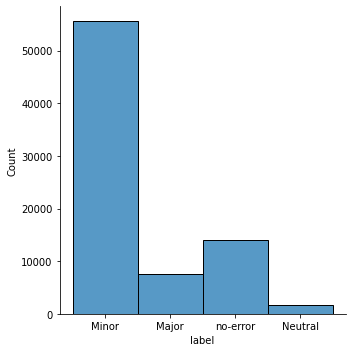

In [36]:
sns.displot(df, x="label")

In [37]:
df[feature_names] = df[feature_names].astype(float)
le = preprocessing.LabelEncoder()
le.fit(df.label)
df[['label']]  = le.transform(df.label).reshape(-1,1)
df[['label']] =  df[['label']].astype(int)
df[df == "nan"] = np.nan

In [38]:
df.dtypes

Num token               float64
Num char                float64
Avg word length         float64
Num ADJ                 float64
Num ADP                 float64
                         ...   
Num PronType=Int,Rel    float64
Num PronType=Tot        float64
Num Style=Arch          float64
Num Style=Coll          float64
label                     int64
Length: 122, dtype: object

In [39]:
(df.corr()
 .reset_index()
 .melt(id_vars="index", value_name="corr")
 .loc[lambda df: df["index"] < df["variable"]] # to get lower triangular part of the matrix
 .loc[lambda df: df["corr"] > 0.6]
)

,index,variable,corr
1,Num char,Num token,0.694012
15,Num PUNCT,Num token,0.603200
166,Num Number=Sing,Num char,0.606512
3302,Num DET,Num Definite=Def,0.815132
4891,Num NUM,Num NumType=Card,0.930844
6108,Num DET,Num PronType=Art,0.857165
6127,Num Definite=Def,Num PronType=Art,0.934136
7113,Num Mood=Ind,Num VerbForm=Fin,0.721766
8376,"Num Gender[psor]=Masc,Neut",Num Number[psor]=Sing,0.903188
8934,Num Definite=Ind,Num PronType=Ind,0.722050


In [40]:
y = "label"
x = feature_names

converter = DFtoVW.from_colnames(df=df, y=y, x=x)
examples = converter.convert_df()

/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num token' was not a valid feature/namespace name. It has been renamed 'Num_token'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num char' was not a valid feature/namespace name. It has been renamed 'Num_char'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Avg word length' was not a valid feature/namespace name. It has been renamed 'Avg_word_length'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num ADJ' was not a valid feature/namespace name. It has been renamed 'Num_ADJ'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DF

In [46]:
model = vw(
    enable_logging=True,
    csoaa=4)

import random
examples = list(set(examples))
random.shuffle(examples)
train_examples, test_examples = train_test_split(examples, test_size=0.25, random_state=42)

for ex in train_examples:
    model.learn(ex)

model.finish()

In [47]:
model.get_log()

['Num weight bits = 18\n',
 'learning rate = 0.5\n',
 'initial_t = 0\n',
 'power_t = 0.5\n',
 'using no cache\n',
 'Reading datafile = \n',
 'num sources = 1\n',
 'Enabled reductions: gd, scorer, csoaa\n',
 'average  since         example        example  current  current  current\n',
 'loss     last          counter         weight    label  predict features\n',
 '    n.a.     n.a.            1            1.0  unknown        1       16\n',
 '    n.a.     n.a.            2            2.0  unknown        0       34\n',
 '    n.a.     n.a.            4            4.0  unknown        1       34\n',
 '    n.a.     n.a.            8            8.0  unknown        0       25\n',
 '    n.a.     n.a.           16           16.0  unknown        1       33\n',
 '    n.a.     n.a.           32           32.0  unknown        1       43\n',
 '    n.a.     n.a.           64           64.0  unknown        1       33\n',
 '    n.a.     n.a.          128          128.0  unknown        0       27\n',
 '  

In [65]:
fe = FeatureExtractor()

2022-01-21 07:50:57 INFO: Downloading default packages for language: de (German)...
2022-01-21 07:50:58 INFO: File exists: /home/ahmet/stanza_resources/de/default.zip.
2022-01-21 07:51:01 INFO: Finished downloading models and saved to /home/ahmet/stanza_resources.
2022-01-21 07:51:01 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| sentiment | sb10k   |
| ner       | conll03 |

2022-01-21 07:51:01 INFO: Use device: gpu
2022-01-21 07:51:01 INFO: Loading: tokenize
2022-01-21 07:51:04 INFO: Loading: mwt
2022-01-21 07:51:04 INFO: Loading: pos
2022-01-21 07:51:04 INFO: Loading: lemma
2022-01-21 07:51:04 INFO: Loading: depparse
2022-01-21 07:51:04 INFO: Loading: sentiment
2022-01-21 07:51:04 INFO: Loading: ner
2022-01-21 07:51:05 INFO: Done loading processors!


2022-01-21 07:51:05 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package  |
------------------------------
| tokenize        | combined |
| pos             | combined |
| lemma           | combined |
| depparse        | combined |
| sentiment       | sstplus  |
| constituency    | wsj      |
| ner             | conll03  |
| forward_charlm  | 1billion |
| backward_charlm | 1billion |
| pretrain        | combined |

2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/tokenize/combined.pt.
2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/pos/combined.pt.
2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/lemma/combined.pt.
2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/depparse/combined.pt.
2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/sentiment/sstplus.pt.
2022-01-21 07:51:05 INFO: File exists: /home/ahmet/stanza_resources/en/const

In [82]:
model.predict(format_input("hi", "hallo"))

/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num token' was not a valid feature/namespace name. It has been renamed 'Num_token'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num char' was not a valid feature/namespace name. It has been renamed 'Num_char'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Avg word length' was not a valid feature/namespace name. It has been renamed 'Avg_word_length'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DFtoVW.py:53: UserWarning: Name 'Num ADJ' was not a valid feature/namespace name. It has been renamed 'Num_ADJ'
  warnings.warn(
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/vowpalwabbit/DF

1

In [61]:
y_pred = []
y_true = []
for ex in test_examples:
    y_pred.append(model.predict(ex[3:]))
    y_true.append(int(ex[:1]))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    1105.0
           1       0.00      0.00      0.00    3358.0
           2       0.00      0.00      0.00     356.0
           3       0.00      0.00      0.00    1694.0
     3359329       0.00      0.00      0.00       0.0

    accuracy                           0.00    6513.0
   macro avg       0.00      0.00      0.00    6513.0
weighted avg       0.00      0.00      0.00    6513.0



/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [49]:
confusion_matrix(y_true, y_pred)

array([[1105,    0,    0,    0],
       [   0, 3358,    0,    0],
       [   0,    0,  356,    0],
       [   0,    0,    0, 1694]])

In [32]:
log_parser = VWLogParser(model.get_log())
params, df_iter, summary_metrics = log_parser.parse()

ValueError: could not convert string to float: 'n.a.'

In [47]:
print("Model's parameters")
display(params)
print("\n")

print("Information at each iteration")
display(df_iter)
print("\n")

print("Summary metrics")
display(summary_metrics)

Model's parameters


{'Num weight bits': 18,
 'learning rate': 0.5,
 'initial_t': 0,
 'power_t': 0.5,
 'Reading datafile': '',
 'num sources': 1,
 'Enabled reductions': 'gd, scorer'}



Information at each iteration


,average_loss,since_last,example_counter,example_weight,current_label,current_predict,current_features
0,1.000000,1.000000,1,1.0,1.0,0.0000,28
1,1.000000,1.000000,2,2.0,0.0,1.0000,28
2,0.500000,0.000000,4,4.0,3.0,1.1048,27
3,0.250000,0.000000,8,8.0,3.0,1.2728,28
4,0.125000,0.000000,16,16.0,1.0,1.3036,32
5,0.187500,0.250000,32,32.0,1.0,1.1790,28
6,0.158178,0.128857,64,64.0,1.0,1.0578,23
7,0.118152,0.078125,128,128.0,1.0,1.4652,31
8,0.093649,0.069147,256,256.0,3.0,1.0000,25
9,0.100148,0.106646,512,512.0,1.0,1.0000,24




Summary metrics


{'number of examples': 79020,
 'weighted example sum': 79020,
 'weighted label sum': 101233,
 'average loss': 0.096451,
 'total feature number': 2429049}

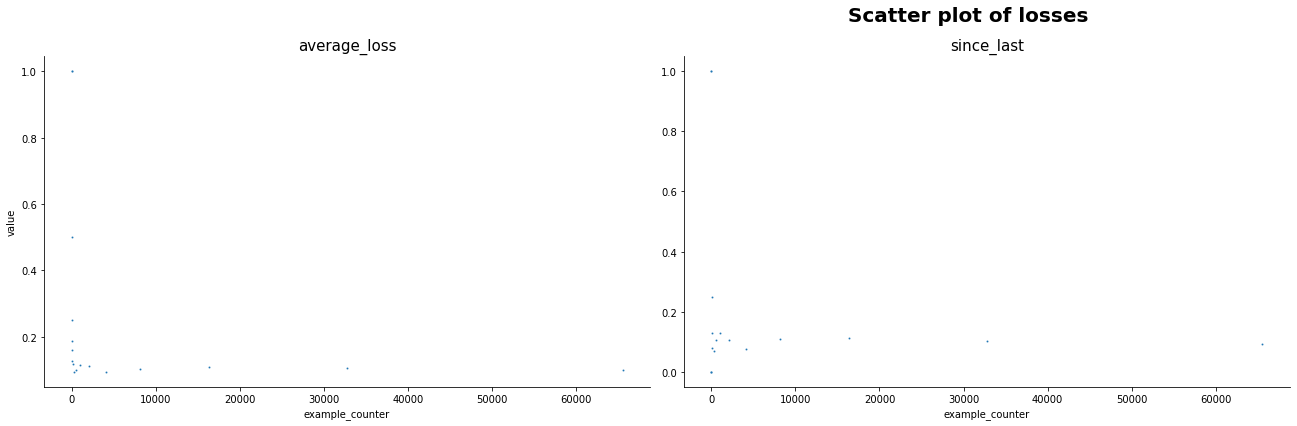

In [53]:
scatter_var = ["average_loss", "since_last"]
g = sns.relplot(data=df_iter[scatter_var + ["example_counter"]].melt(id_vars="example_counter"), 
                x="example_counter", y="value", col="variable",
                col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, 
                kind="scatter", s=4, height=6, aspect=1.5, alpha=1)
g.fig.suptitle('Scatter plot of losses', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)
g.fig.tight_layout()

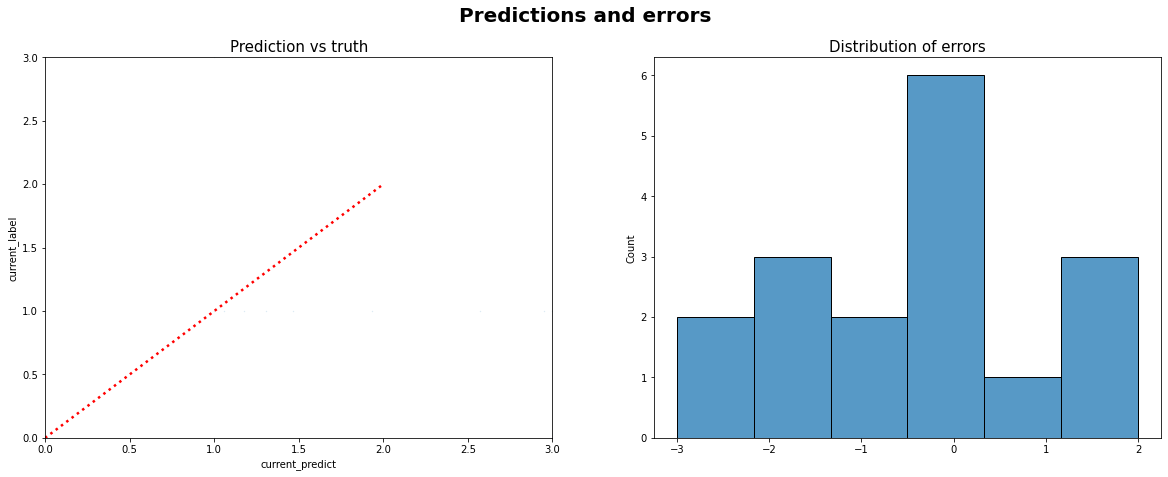

In [55]:
start_idx = 00_000
error = df_iter.current_label - df_iter.current_predict

f, (ax1, ax2) = plt.subplots(figsize=(20, 7), ncols=2)
f.suptitle('Predictions and errors', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

# Scatterplot pred vs truth
sns.scatterplot(data=df_iter.loc[start_idx:], x="current_predict", y="current_label", ax=ax1, s=2, alpha=.15)
ax1.set_title("Prediction vs truth", fontsize=TITLE_FONTSIZE)
max_range = int(df_iter[["current_label", "current_predict"]].quantile(.99).max())
ax1.set_xlim([0, max_range])
ax1.set_ylim([0, max_range])

# Adding x=y line
#range_x = range(0, int(df_iter[["current_predict", "current_label"]].max().min()))
range_x = range(0, max_range)
ax1.plot(range_x, range_x, linestyle=":", color="red", linewidth=2.5)

# Histogram of errors
sns.histplot(error[start_idx:], ax=ax2)
ax2.set_title("Distribution of errors", fontsize=TITLE_FONTSIZE)

plt.show()

In [64]:
model.predict(examples[5500])

2.861820697784424